In [1]:
import numpy as np
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# [LightGBM](https://github.com/Microsoft/LightGBM)

LightGBM (Light Gradient Boosted Machine) — open source библиотека бустинга, от Microsoft. 

### Что позволяет LightGBM работать быстрее обычного бустинга?

Важный и затратный по времени шаг — построение дерева решений, требующий O(объём данных * кол-во признаков (feature)) времени.<br>
LightGBM использует алгоритмы **GOSS** и **EFB** для его ускорения. Первый уменьшает размер выборки, второй — количество фич.

In [ ]:
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

def classifiers_time(classifiers, runs):
    X, y = make_classification(n_samples=1250, n_features=60, n_informative=20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    n_classifiers = len(classifiers)
    times = np.empty((n_classifiers, 0)).tolist()
    accuracies = np.empty((n_classifiers, 0)).tolist()
    for run in tqdm(range(runs)):
        for i in range(n_classifiers):
            t = time.time()
            classifiers[i].fit(X_train, y_train)
            elapsed = time.time() - t
            times[i].append(elapsed)

            pred = classifiers[i].predict(X_test)
            accuracies[i].append(accuracy_score(y_test, pred))
    return times, accuracies

In [ ]:
import matplotlib.pyplot as plt

def plot_classifiers_time(ys, names, y_name):
    plt.figure(figsize=(12, 8))
    for i in range(len(names)):
        plt.plot(ys[i], label=names[i])
    plt.legend()
    plt.xlabel('Iteration number')
    plt.ylabel(y_name)
    plt.show()

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


classifiers = [lgbm.LGBMClassifier(boosting_type='goss'), XGBClassifier(), CatBoostClassifier()]
times, accuracies = classifiers_time(classifiers, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.6644896	total: 62.3ms	remaining: 12.4s
5:	learn: 0.6588619	total: 75ms	remaining: 12.4s
6:	learn: 0.6534255	total: 87.5ms	remaining: 12.4s
7:	learn: 0.6461601	total: 100ms	remaining: 12.4s
8:	learn: 0.6382872	total: 113ms	remaining: 12.4s
9:	learn: 0.6334641	total: 125ms	remaining: 12.4s
10:	learn: 0.6273804	total: 138ms	remaining: 12.4s
11:	learn: 0.6234948	total: 150ms	remaining: 12.4s
12:	learn: 0.6173331	total: 164ms	remaining: 12.5s
13:	learn: 0.6107906	total: 176ms	remaining: 12.4s
14:	learn: 0.6053170	total: 189ms	remaining: 12.4s
15:	learn: 0.6010356	total: 216ms	remaining: 13.3s
16:	learn: 0.5960404	total: 229ms	remaining: 13.2s
17:	learn: 0.5887914	total: 241ms	remaining: 13.1s
18:	learn: 0.5845074	total: 253ms	remaining: 13.1s
19:	learn: 0.5772310	total: 265ms	remaining: 13s
20:	learn: 0.5713434	total: 277ms	remaining: 12.9s
21:	learn: 0.5677306	total: 289ms	remaining: 12.8s
22:	learn: 0.5628977	

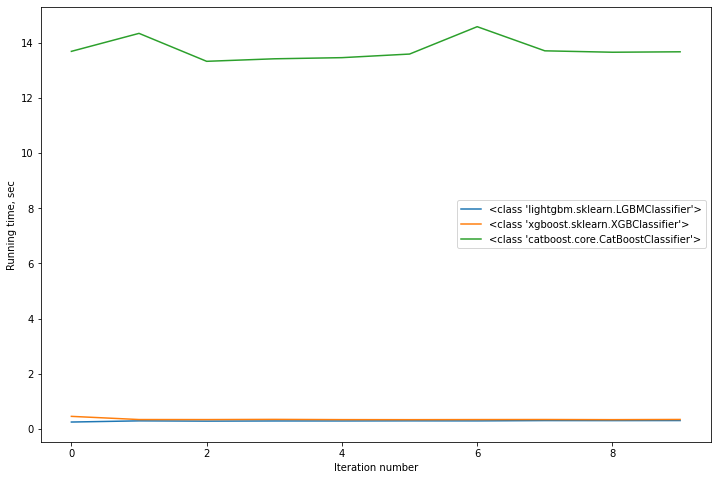

In [ ]:
names = list(map(lambda x: str(x.__class__), classifiers))
plot_classifiers_time(times, names, 'Running time, sec')

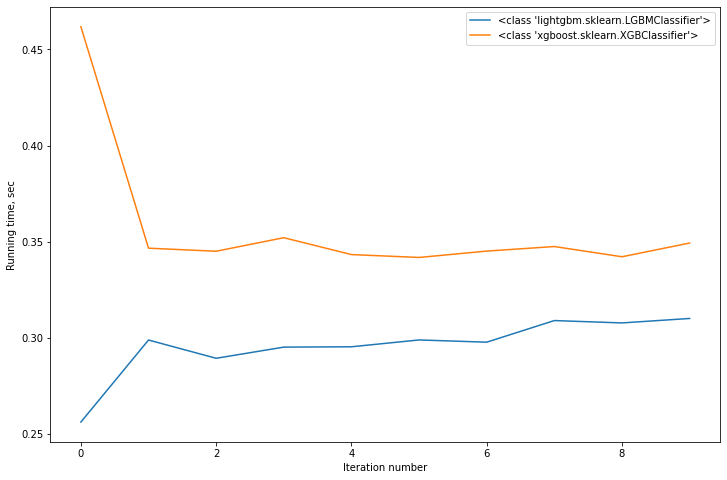

In [ ]:
plot_classifiers_time(times[:2], names[:2], 'Running time, sec')

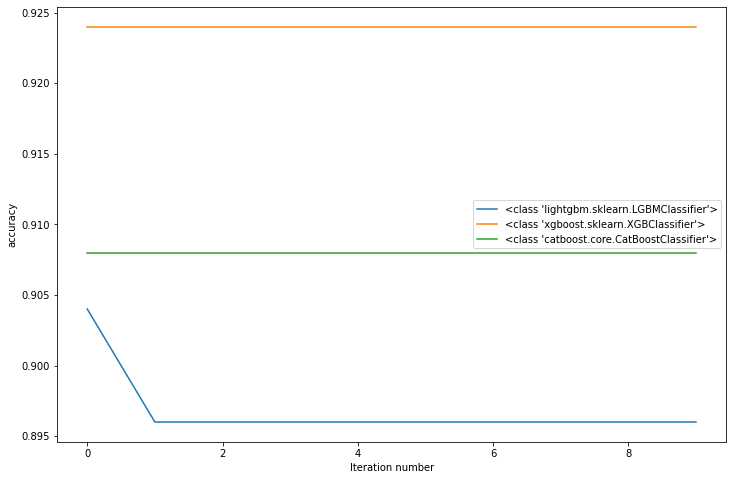

In [ ]:
plot_classifiers_time(accuracies, names, 'accuracy')

### **GOSS** — Gradient-based One Side Sampling
Метод уменьшения выборки с учётом градиента. Объекты с маленькими градиентами дают небольшую ошибку, следовательно, экземпляры с большими градиентами сильнее влияют на обучение. Идея GOSS состоит в отбрасывании случайных объектов с небольшими градиентами и перебалансировке оставшейся выборки. 

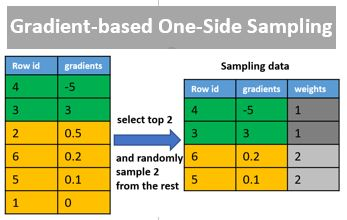

In [ ]:
Image('images/goss.jpg')

$X$ - выборка<br>
$a (0 < a < len(X))$ — количество сохраняемых объектов с большими градиентами<br>
$b (0 < b \leq len(X) - a )$ — количество переносящихся в новую выборку объектов с небольшими градиентами

#### Алгоритм:
* Данная выборка сортируется по убыванию градиентов
* Первые $a$ объектов сохраняются в новую выборку
* $b$ случайных объектов из оставшихся $(len(X) - a)$ сохраняются в новую выборку с весами $\frac{len(X) - a}{b}$

По умолчанию LightGBM использует GOSS для первых $\frac{1}{learning\_rate}$ итераций. Чтобы испольховать GOSS на каждой, нужно указать параметр `"boosting" : goss` при создании модели.

In [ ]:
сlassifiers = [
    lgbm.LGBMClassifier(boosting_type='gbdt'),
    lgbm.LGBMClassifier(boosting_type='goss'),
    lgbm.LGBMClassifier(boosting_type='dart')]
times, accuracies = classifiers_time(сlassifiers, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

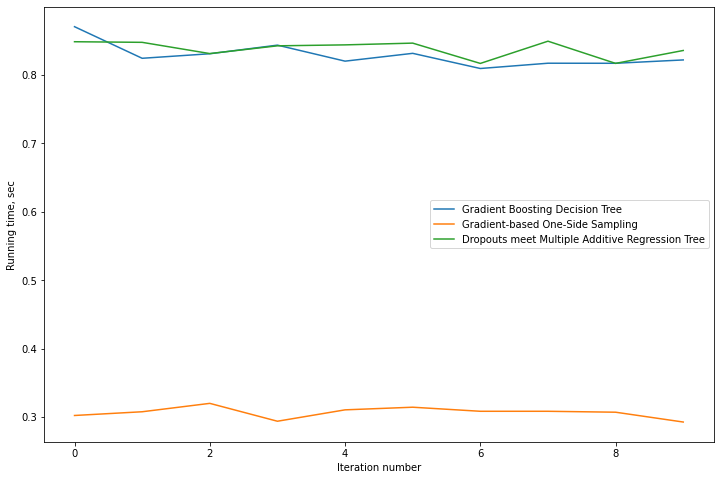

In [ ]:
plot_classifiers_time(times, [
    'Gradient Boosting Decision Tree', 
    'Gradient-based One-Side Sampling', 
    'Dropouts meet Multiple Additive Regression Tree'], 'Running time, sec')

In [ ]:
print('Gradient Boosting Decision Tree:', np.mean(accuracies[0]))
print('Gradient-based One-Side Sampling', np.mean(accuracies[1]))
print('Dropouts meet Multiple Additive Regression Tree', np.mean(accuracies[2]))

Gradient Boosting Decision Tree: 0.828
Gradient-based One-Side Sampling 0.792
Dropouts meet Multiple Additive Regression Tree 0.8240000000000001


### **EFB** — Exclusive Feature Bundling
Количество фич можно значительно сократить, если среди них встречается много взаимоисключающих, не принимающих одновременно нулевые значения признаков. EFB объединяет такие фичи в `bundles`.

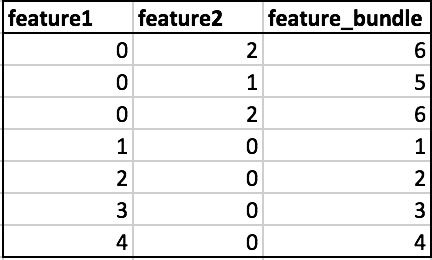

In [ ]:
Image('images/efb.png')

Конфликт — количество различных перекрывающихся ненулевых значений.

Алгоритм:
* Заводится массив `bundles` и пороговое значение количества конфликтов `threshold`
* Подсчитываются конфликты между всеми фичами
* Фичи сортируются в порядке убывания количества ненулевых значений
* В цикле по отсортированным фичам:
    - если при добавлении фичи в последний `bundle` конфликт не превышает порога, фича добавляется
    - иначе — в массив кладётся новый `bundle`, куда добавляется фича
Объединение фич внутри каждого `bundle` в одну:
* Рассчитывается такое смещение для каждой из фич, чтобы была биекция между суммой значений со смещениями и первоначальными комбинациями значений фич
* Смещения прибавляются к фичам
* Значения по каждому объекту суммируются

Задача нахождения оптимального объединения фич NP-полная, алгоритм EFB был выбран в результате экспериментов.



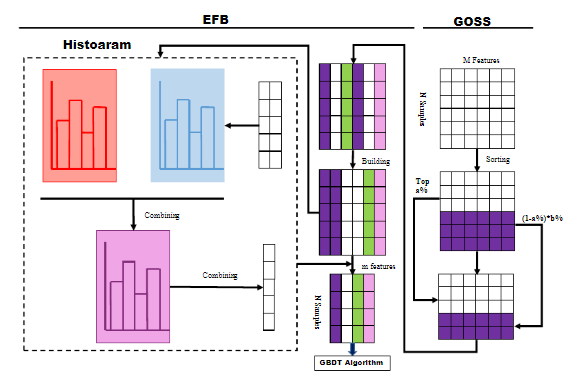

In [ ]:
Image('images/full_goss_efb.png')

In [ ]:
import pandas as pd

df = pd.read_csv('data/forest_train.csv')
X = df.drop(columns=['Cover_Type', 'Id']).reset_index(drop=True)
y = df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.3)

classifiers = [lgbm.LGBMClassifier(), lgbm.LGBMClassifier().set_params(enable_bundle=False)]
times = [[], []]
accuracies = [[], []]

for i in tqdm(range(10)):
    for j in range(2):
         t = time.time()
         classifiers[j].fit(X_train, y_train)
         elapsed = time.time() - t
         times[j].append(elapsed)

         pred = classifiers[j].predict(X_test)
         accuracies[j].append(accuracy_score(y_test, pred))

  0%|          | 0/10 [00:00<?, ?it/s]

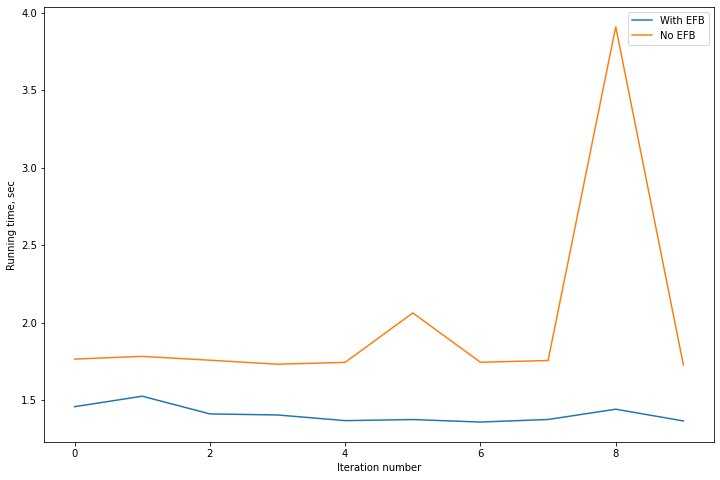

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(times[0], label='With EFB')
plt.plot(times[1], label='No EFB')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.show()

In [ ]:
print('EFB:', np.mean(accuracies[0]))
print('No EFB:', np.mean(accuracies[1]))

EFB: 0.8068783068783068
No EFB: 0.8068783068783068


### Принцип построения дерева решений LightGBM
Многие алгоритмы строят дерево выборов "в ширину", по уровням (`level-wise growth`), тогда как LightGBM — best-first до листьев (**`leaf-wise growth`**). Среди листьев находится тот, углубление по которому приведёт к максимальному уменьшению потери, благодаря этому `leaf-wise`-деревья могут давать меньшие ошибки чем `level-wise`<br>
При таком подходе `One-Hot Encoding` преобразование категориальных фич (замена одной фичи на множество со значениями 1 и 0) может привести к сильному росту дерева в глубину, для контроля глубины дерева есть параметр `max_depth`. LightGBM поддерживает работу с категориальными фичами без использования `One-Hot Encoding`.

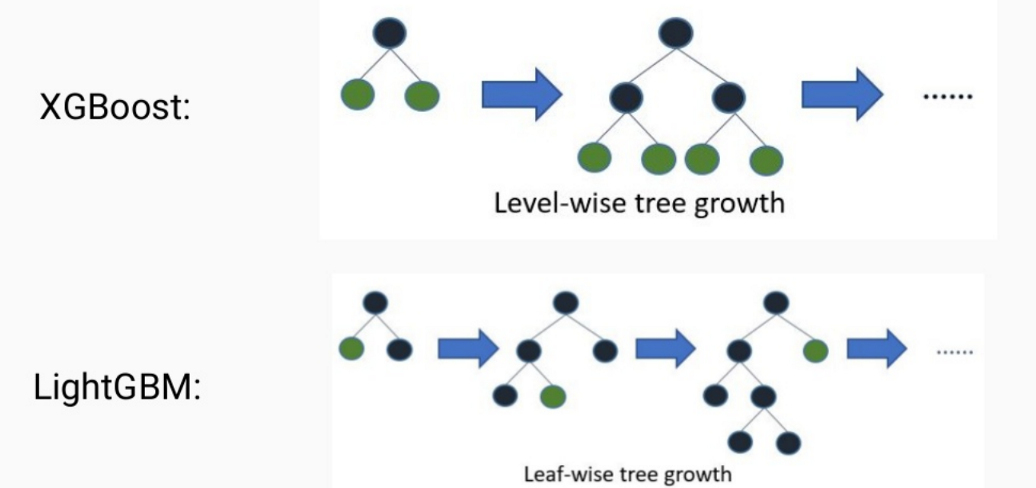

In [ ]:
Image('images/Lwise_growth.png')

In [ ]:
X, y = make_classification(n_samples=500, n_features=40, n_informative=20)
lgbm_c = lgbm.LGBMClassifier().fit(X, y)
xgboost_c = XGBClassifier().fit(X, y)

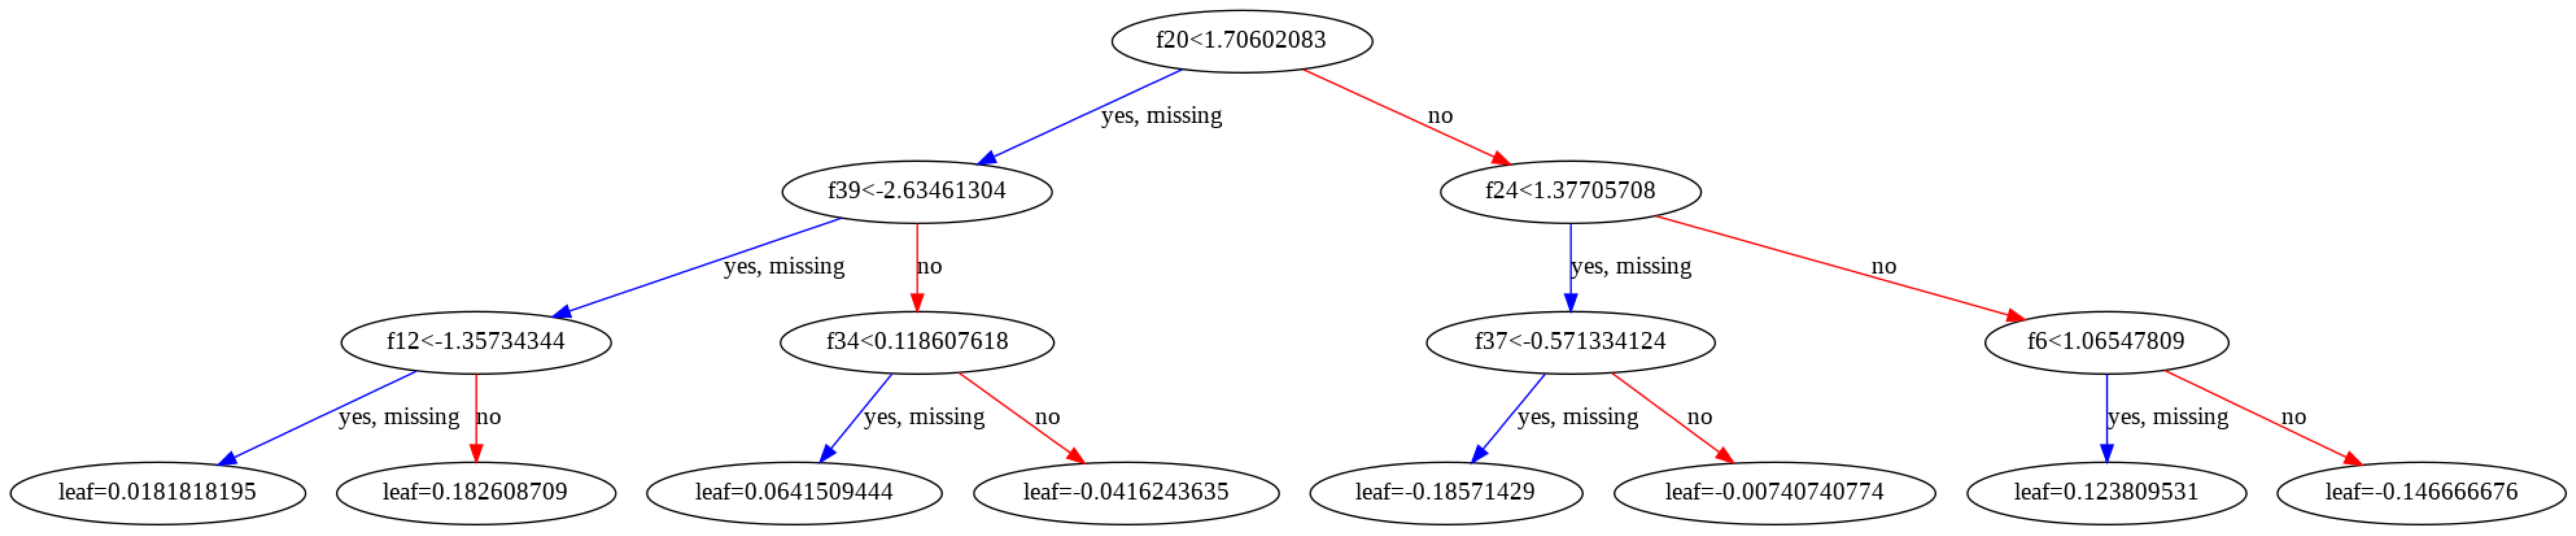

In [ ]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 80,50
plot_tree(xgboost_c)

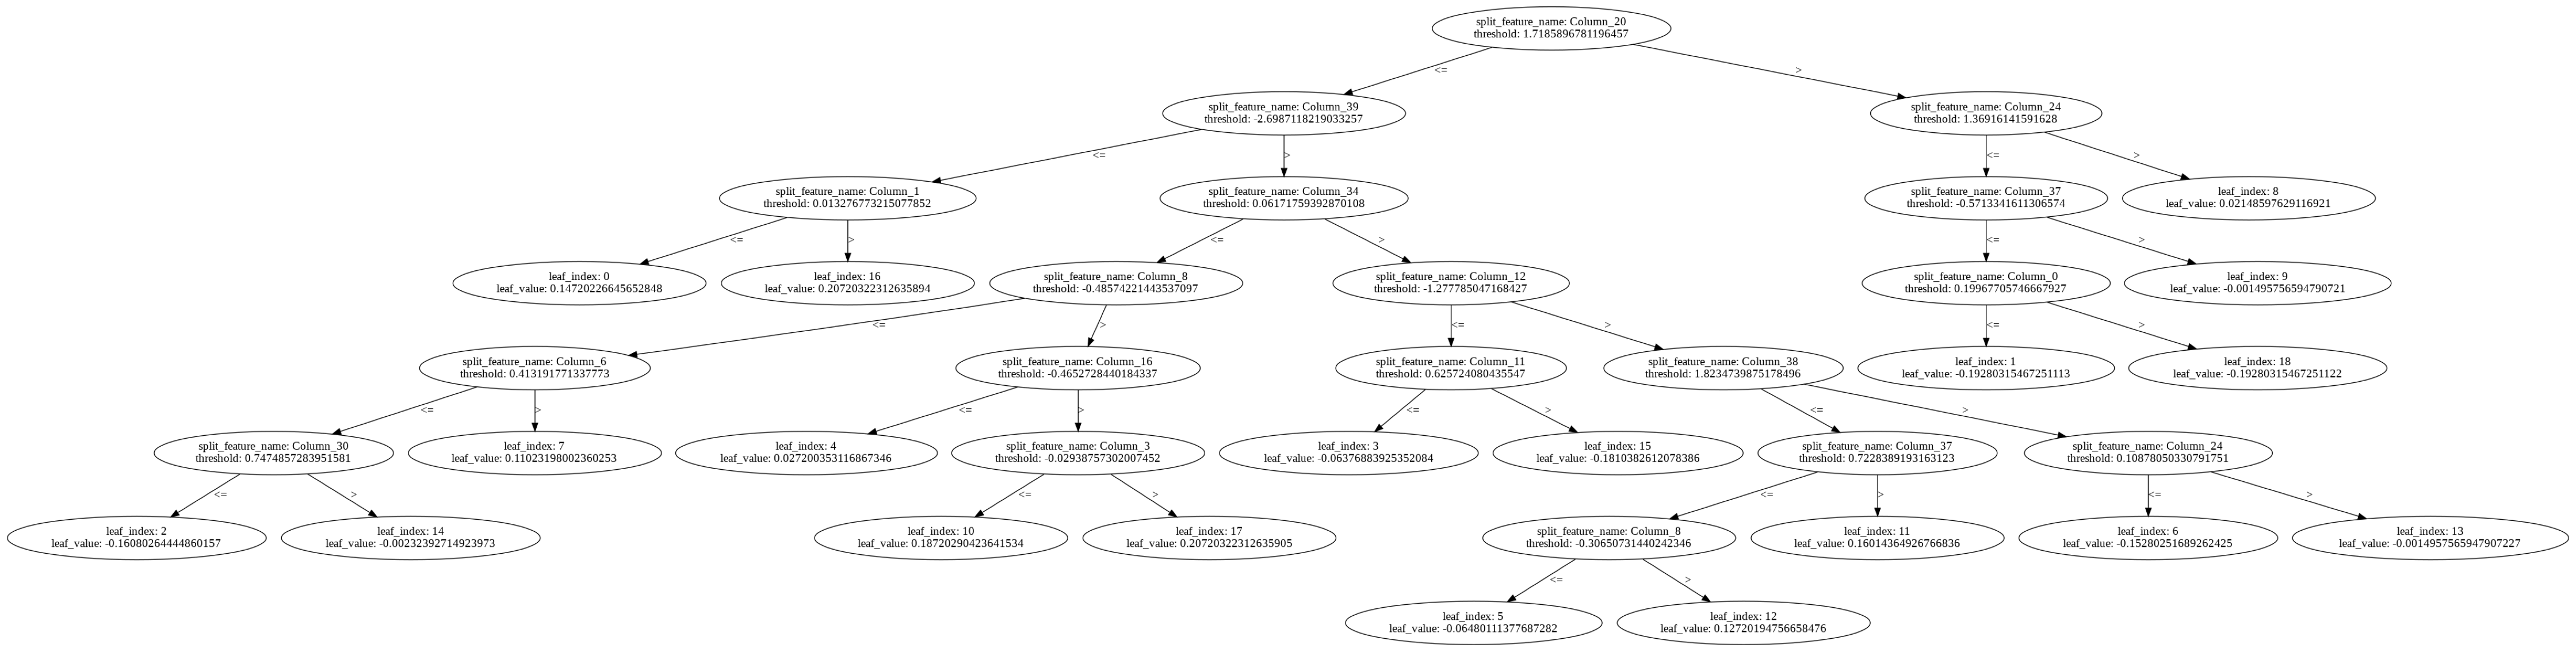

In [ ]:
lgbm.plot_tree(lgbm_c)

## Примеры:

### Примеры классификации:

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
num_classes = len(iris.target_names)

train_dataset = lgbm.Dataset(X_train, y_train, feature_name=iris.feature_names)
test_dataset = lgbm.Dataset(X_test, y_test, feature_name=iris.feature_names)

#### С указанием параметров для классификации:

Подробнее о параметрах в [документации](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

In [ ]:
params = {
          "objective" : "multiclass",
          "num_class" : num_classes,
          "num_leaves" : 60,
          "max_depth": -1,           # значение по умолчанию, отсутствие ограничения глубины
          "learning_rate" : 0.01,    # 0.1 по умолчанию
          "verbosity" : -1 }
bst = lgbm.train(params, train_dataset, 100, valid_sets=[train_dataset])

[1]	training's multi_logloss: 1.07452
[2]	training's multi_logloss: 1.06151
[3]	training's multi_logloss: 1.04875
[4]	training's multi_logloss: 1.03622
[5]	training's multi_logloss: 1.02393
[6]	training's multi_logloss: 1.01186
[7]	training's multi_logloss: 1.00001
[8]	training's multi_logloss: 0.988368
[9]	training's multi_logloss: 0.976936
[10]	training's multi_logloss: 0.965815
[11]	training's multi_logloss: 0.954879
[12]	training's multi_logloss: 0.944123
[13]	training's multi_logloss: 0.933544
[14]	training's multi_logloss: 0.923136
[15]	training's multi_logloss: 0.912896
[16]	training's multi_logloss: 0.90282
[17]	training's multi_logloss: 0.892903
[18]	training's multi_logloss: 0.883039
[19]	training's multi_logloss: 0.87343
[20]	training's multi_logloss: 0.86397
[21]	training's multi_logloss: 0.854657
[22]	training's multi_logloss: 0.845486
[23]	training's multi_logloss: 0.836456
[24]	training's multi_logloss: 0.827563
[25]	training's multi_logloss: 0.818803
[26]	training's mul

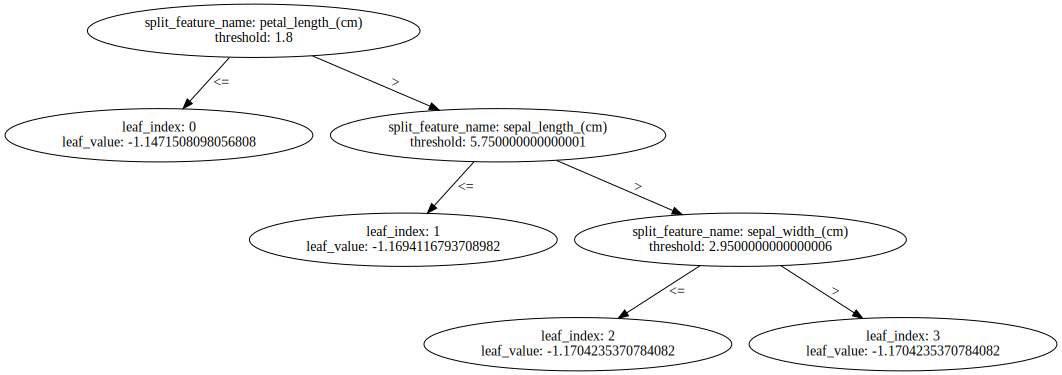

In [ ]:
lgbm.create_tree_digraph(bst)

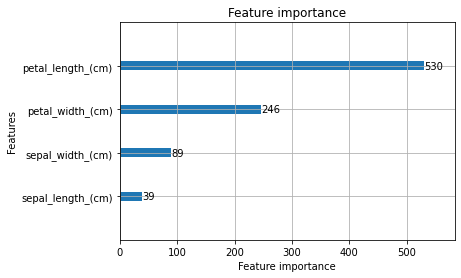

In [ ]:
lgbm.plot_importance(bst)

In [ ]:
y_pred =np.argmax(bst.predict(X_test),axis=1)
y_pred, y_test

(array([2, 2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1,
        0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0]),
 array([2, 1, 0, 0, 2, 0, 2, 2, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0,
        0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0]))

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.75      0.60      0.67         5
           2       0.90      1.00      0.95        18

    accuracy                           0.92        38
   macro avg       0.88      0.84      0.86        38
weighted avg       0.92      0.92      0.92        38

[[14  1  0]
 [ 0  3  2]
 [ 0  0 18]]


#### Либо с использованием классификатора:

In [ ]:
сlassifier = lgbm.LGBMClassifier()
сlassifier.fit(X_train, y_train)
сlassifier_y_pred = сlassifier.predict(X_test)
print(classification_report(y_test, сlassifier_y_pred))
print(confusion_matrix(y_test, сlassifier_y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.60      0.75         5
           2       0.90      1.00      0.95        18

    accuracy                           0.95        38
   macro avg       0.97      0.87      0.90        38
weighted avg       0.95      0.95      0.94        38

[[15  0  0]
 [ 0  3  2]
 [ 0  0 18]]


In [ ]:
сlassifier.booster_.feature_importance()

array([134, 209, 350, 215])

### Примеры регрессии:

In [13]:
from sklearn.metrics import mean_squared_error

from sklearn.datasets import fetch_california_housing

def draw_regression(y_test, y_pred):
    x_ax = range(len(y_test))
    plt.figure(figsize=(27, 9))
    plt.plot(x_ax, y_test, label="original")
    plt.plot(x_ax, y_pred, label="predicted")
    plt.legend(fancybox=True)
    plt.grid(True)
    plt.show() 

In [17]:
california_housing = fetch_california_housing()
X, y = california_housing.data[:1000], california_housing.target[:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y)

train_dataset = lgbm.Dataset(X_train, y_train)
test_dataset = lgbm.Dataset(X_test, y_test)

#### С указанием параметров:

In [18]:
params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 100,
    'verbose': -1
}
model = lgbm.train(params, train_dataset, 1500, valid_sets=[train_dataset])

[1]	training's l2: 0.786882
[2]	training's l2: 0.775025
[3]	training's l2: 0.763398
[4]	training's l2: 0.752012
[5]	training's l2: 0.740854
[6]	training's l2: 0.729911
[7]	training's l2: 0.719183
[8]	training's l2: 0.708652
[9]	training's l2: 0.698348
[10]	training's l2: 0.688271
[11]	training's l2: 0.678414
[12]	training's l2: 0.668699
[13]	training's l2: 0.659226
[14]	training's l2: 0.649826
[15]	training's l2: 0.640484
[16]	training's l2: 0.631401
[17]	training's l2: 0.622451
[18]	training's l2: 0.613722
[19]	training's l2: 0.605072
[20]	training's l2: 0.59661
[21]	training's l2: 0.588301
[22]	training's l2: 0.580167
[23]	training's l2: 0.57229
[24]	training's l2: 0.564421
[25]	training's l2: 0.556789
[26]	training's l2: 0.549329
[27]	training's l2: 0.541944
[28]	training's l2: 0.53471
[29]	training's l2: 0.527572
[30]	training's l2: 0.520546
[31]	training's l2: 0.513685
[32]	training's l2: 0.506985
[33]	training's l2: 0.500353
[34]	training's l2: 0.493873
[35]	training's l2: 0.4875

In [22]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

0.15816225533880662


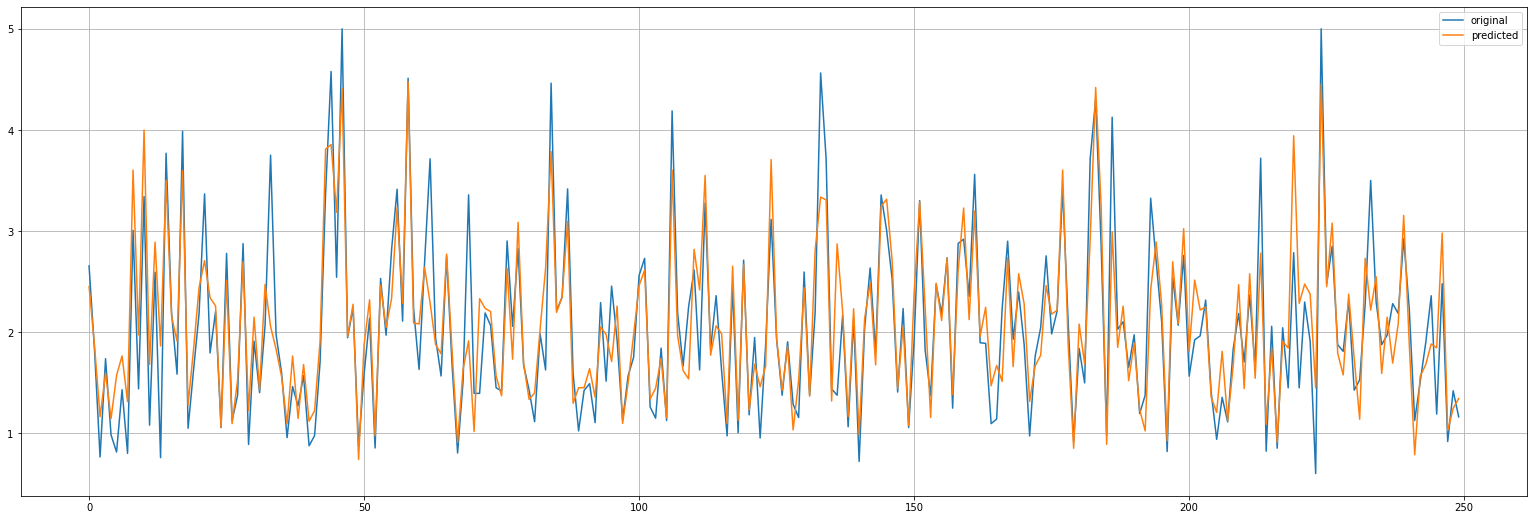

In [20]:
draw_regression(y_test, y_pred)

#### С использованием регрессора:

0.15816225533880662


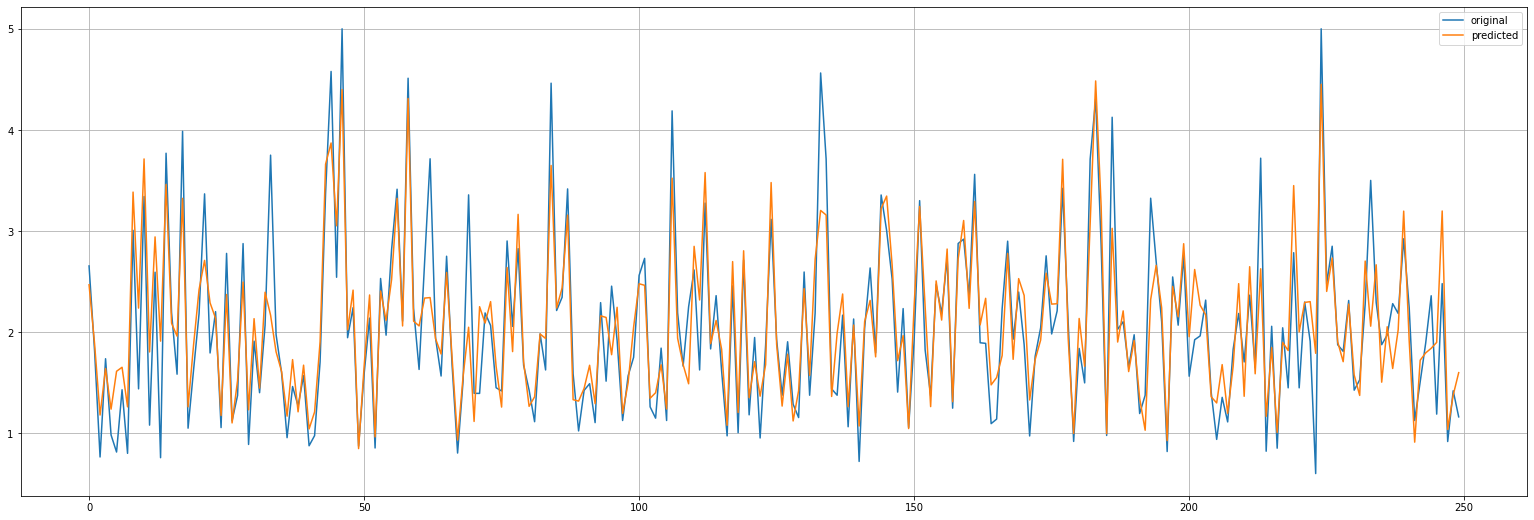

In [21]:
model = lgbm.LGBMRegressor(learning_rate=0.08, n_estimators=50, min_child_weight=0.01)
model.fit(X_train, y_train)
regressor_y_pred = model.predict(X_test)
print(mean_squared_error(y_test, regressor_y_pred))
draw_regression(y_test, regressor_y_pred)

## Ссылки

[Документация](https://lightgbm.readthedocs.io/en/v3.3.2/index.html)<br>
[Статья об оптимизациях LightGBM (GOSS и EFB)](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf)<br>
[Статья на Хабре с исследованием деревьев и скорости обучения](https://habr.com/ru/company/skillfactory/blog/530594/)